In [11]:
using Pkg
Pkg.activate(".")

  Activating environment at `~/git/mine/2021SSA-Julia/Project.toml`


In [12]:
Pkg.add("Distributions")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/git/mine/2021SSA-Julia/Project.toml`
  No Changes to `~/git/mine/2021SSA-Julia/Manifest.toml`
   Resolving package versions...
  No Changes to `~/git/mine/2021SSA-Julia/Project.toml`
  No Changes to `~/git/mine/2021SSA-Julia/Manifest.toml`


In [13]:
Pkg.status()

      Status `~/git/mine/2021SSA-Julia/Project.toml`
  [31c24e10] Distributions v0.25.10
  [91a5bcdd] Plots v1.18.1


In [4]:
########################################################
## This is a merged cell of all of the Simulation code #
########################################################

using Distributions, Plots

"""
Returns an array of points around the point (i,j) to which we can move.

Assumes global values `M` and `N`.
"""
function calc_move_options(i,j)
    options = Array{Array{Int,1},1}(undef,0)
    for k = i-1:i+1
        for l = j-1:j+1
            [k,l] != [i,j] && push!(options,[k,l])
        end
    end
    filter((c)->(c[1]>0 && c[1]<=M && c[2]>0 && c[2]<=N),  options)
end


"""
Sets global parameters.
"""
function init_params(;
    γ_ = 0.2, #aspect ratio (height/width)
    ρ_ = 0.2, #density
    p₀_ = 0.01, #initial infection  p₀   p + \ + _ + 0 + [TAB]
    μ_ = 15, #mean infection duration
    area_ = 10^4, # ≈ M*N,
    verbose = true
    )

    global γ = γ_
    global ρ = ρ_
    global p₀ = p₀_
    global μ = μ_
    global N = Int(round(sqrt(area_/γ))) #Based on area and aspect ratio we can get N
    
    global M = Int(round(γ * N)) #height of space implied by aspect ratio
    verbose && @show M
    verbose && @show M*N

    global n = Int(floor(ρ*M*N)) #number of agents implied by area and 
    verbose && @show n;

    #Big memory usage to create move_options
    global move_options = [calc_move_options(i,j) for i in 1:M, j in 1:N]
end

"""
The basic agent structure.
"""
mutable struct Agent #structs are by default immutable
    vert_loc::Int
    horz_loc::Int
    state::Symbol   #Assumed to be :S , :I,  :R
    time_sick_left::Int
    id::Int
end


"""
Move an agent to a random position.
"""
function move!(agent::Agent)
    i, j = rand(move_options[agent.vert_loc,agent.horz_loc])
    agent.vert_loc, agent.horz_loc = i, j #assigning two values in one line
    agent
end


"""
Duration of sickness.
"""
time_sick_init() = rand(Poisson(μ-1)) + 1

"""
Initilize agents.
"""
init_agents() = [ Agent(rand(1:M),
                        rand(1:N),
                        rand() <= p₀ ? :I : :S,
                        time_sick_init(),
                        id) for id in 1:n]


δ = 0.1;
noise() = rand(Uniform(-0.1,0.1))

function illustrate_agents(agents::Vector{Agent}; title = "")
    #plot black background
    plot(Shape([1-2δ,N+2δ,N+2δ,1-2δ],[1-2δ,1-2δ,M+2δ,M+2δ]),c=:black,label=:none)

    s_agents = filter((a)->a.state == :S,agents)
    x = [a.horz_loc + noise() for a in s_agents]
    y = [a.vert_loc + noise() for a in s_agents]
    scatter!(x, y, 
        c = :green,
        label="Susceptible")
    
    r_agents = filter((a)->a.state == :R, agents)
    x = [a.horz_loc + noise() for a in r_agents]
    y = [a.vert_loc + noise() for a in r_agents]
    scatter!(x, y, 
        c = :yellow,
        label="Removed")

    i_agents = filter((a)->a.state == :I,agents)
    x = [a.horz_loc + noise() for a in i_agents]
    y = [a.vert_loc + noise() for a in i_agents]
    scatter!(x, y, 
        xlim = (0,N+1), ylim = (0,M+1),
        c = :red,
        #framestyle=:none,
        label="Infected",
        legend = :outertopright,
        aspectratio = 1,title = title) 
end

# Query functions for the aggregate of the epidemic
numS(agents) = count((a)->a.state == :S, agents)
numI(agents) = count((a)->a.state == :I, agents)
numR(agents) = count((a)->a.state == :R, agents)

"""
Take a specific `agent` and the vector of all `agents` and infect agent if it is in state `:S` and 
is in the same cell as another infected agent.
"""
function consider_infections(agent::Agent,agents::Vector{Agent})
    agent.state != :S && return #if state is NOT :S then leave
    for a in agents
        agent.id == a.id && continue  #don't infect yourself
        if (agent.vert_loc,agent.horz_loc) == (a.vert_loc, a.horz_loc)
            if a.state == :I 
                agent.state = :I
            end
        end
    end
end

"""
Take a specific `agent` and progress their disease if currently infected. 
Once no time left for sickness agent becomes `:R`.
"""
function progress_disease(agent::Agent)
    agent.state != :I && return
    @assert agent.time_sick_left > 0
    agent.time_sick_left -= 1
    if agent.time_sick_left == 0
        agent.state = :R
    end
end


"""
Run the simulation based on the global variable parameters, modifing the global `agents`.
"""
function run_sim(call_back=(t,a)->nothing ; Tmax = 300) #(t,agents)->nothing is the DEFAUT
    #Initilize empty arrays
    countsS = Array{Int}(undef,0)
    countsI = Array{Int}(undef,0)
    countsR = Array{Int}(undef,0)

    agents = init_agents()
    t = 0
    while t <Tmax #numI(agents)>0 && 
        t+=1

        push!(countsS, numS(agents))
        push!(countsI, numI(agents))
        push!(countsR, numR(agents))

        #(1) MOVE the agnets
        move!.(agents)
        
        #(2) INFECT agents 
        for a in agents
            consider_infections(a,agents)
        end
        
        #(3) PROGRESS sicknesses
        for a in agents 
            progress_disease(a)
        end
        
        #This line executes the call-back
        #This line does nothing by default
        call_back(t,agents)
    end
    
    #Return type is a "named tuple"
    return (    time_range = 1:length(countsS),
                counts_S = countsS,
                counts_I = countsI,
                counts_R = countsR) 
end


"""
Plot 3 simulation runs.
"""
function plot_3_runs()
    results1 = run_sim()
    results2 = run_sim()
    results3 = run_sim()

    plot(results1.time_range, 
        [results1.counts_S results1.counts_I results1.counts_R],
        label = false, 
        c = [:green :red :yellow],lw=3)
    plot!(results2.time_range, 
        [results2.counts_S results2.counts_I results2.counts_R],
        label = false, 
        c = [:green :red :yellow],lw=3)
    plot!(results3.time_range, 
        [results3.counts_S results3.counts_I results3.counts_R],
        label = ["Susceptible" "Infected" "Removed"], 
        c = [:green :red :yellow],
        ylim=(0,n),xlabel="Time", ylabel = "Individuals",
        legend=:outertopright,lw=3)
end


function make_animation(;filename = "epidemic-animation.gif", Tanim = 200)
    anim = Animation()
    
    function plotting_call_back(t,agents)
        if t <= Tanim
            illustrate_agents(agents,title = "Time = $t, Infected = $(numI(agents))")
            frame(anim)
        end 
    end
    
    run_sim(plotting_call_back)
    gif(anim, filename, fps = 5) #5 frames per second
end;

M = 45
M * N = 10080
n = 2016


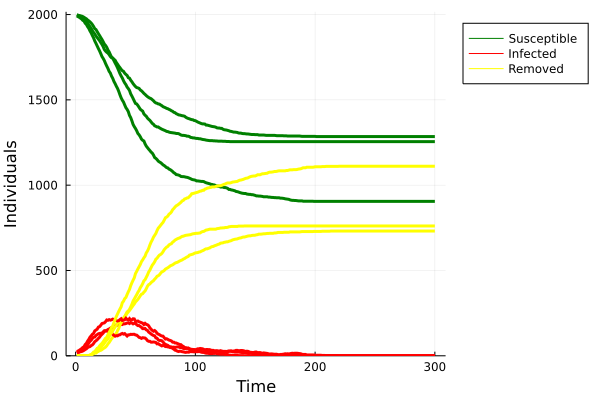

In [2]:
using Random
Random.seed!(0)

init_params()
plot_3_runs()